# Data Preprocessing & Cleaning

This module is used to extract the characters from the licence plate image that will be used in the recognition module.

Use case:

- The main objective of this module is to extract the characters existing in the LP image.


- The second objective is to prepare a dataset containing the different classes of the train model file. This is useful for data enrichment module that is necessary to improve the model training.

!!! Note: You should verify every path in this file before using it.

## Import of necessary libraries

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from pathlib import Path

## 1- Character Segmentation

We redefine here the segmentation funtion defined in the "Data Preprocessing & Cleaning" module to show the example of use, because the prediction input must be a list of LP characters cropped, and each one will be recognised by the deep learning model.

## First method
### Definition of the first method 

In [15]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    #dimensions = [LP_WIDTH/6, LP_WIDTH/2, LP_HEIGHT/10, 2*LP_HEIGHT/3]
    #dimensions = [6, LP_WIDTH-25, LP_HEIGHT/10, 2*LP_HEIGHT/3]
    dimensions = [10, LP_WIDTH-30, LP_HEIGHT/10, 2*LP_HEIGHT/3]
    #print("LP_WIDTH=",LP_WIDTH)
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

In [16]:
#    Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #print(cntrs)
    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        #detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

#             Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) #List that stores the character's binary image (unsorted)
            
    #Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    #arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

## Test of the first method

Note: For this method, we defined the cropped licence plate image with black characters and white background.

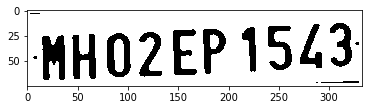

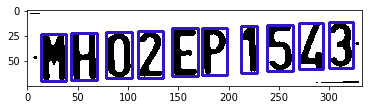

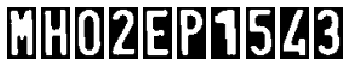

In [17]:
Foreign_LP = cv2.imread('car_plate.png')
char_Foreign_LP = segment_characters(Foreign_LP)
for i in range(len(char_Foreign_LP)):
    plt.subplot(1, len(char_Foreign_LP), i+1)
    plt.imshow(char_Foreign_LP[i], cmap='gray')
    plt.axis('off')
    #print(char[i].shape)


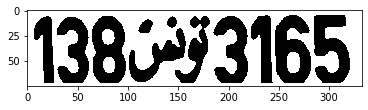

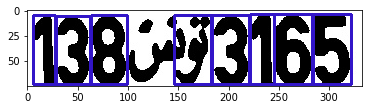

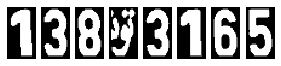

In [18]:
Tunisian_LP = cv2.imread('138TN.png')
char_Tun_LP = segment_characters(Tunisian_LP)
for i in range(len(char_Tun_LP)):
    plt.subplot(1, len(char_Foreign_LP), i+1)
    plt.imshow(char_Tun_LP[i], cmap='gray')
    plt.axis('off')

## Second method

### Definition  of the second method

In [3]:
def histogram_of_pixel_projection(img):
    """
    
    This method is responsible for licence plate segmentation with histogram of pixel projection approach
    
    :param: input image
    
    :return: list of image, each one contain a digit or the word "تونس"
    
    """
    # list that will contains all digits
    caracrter_list_image = list()

    # img = crop(img)

    # Add black border to the image
    BLACK = [0, 0, 0]
    img = cv2.copyMakeBorder(img, 3, 3, 3, 3, cv2.BORDER_CONSTANT, value=BLACK)

    # change to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Change to numpy array format
    nb = np.array(gray)

    # Binarization
    nb[nb > 120] = 255
    nb[nb < 120] = 0

    # compute the sommation
    x_sum = cv2.reduce(nb, 0, cv2.REDUCE_SUM, dtype=cv2.CV_32S)
    y_sum = cv2.reduce(nb, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32S)

    # rotate the vector x_sum
    x_sum = x_sum.transpose()

    # get height and weight
    x = gray.shape[1]
    y = gray.shape[0]

    # division the result by height and weight
    x_sum = x_sum / y
    y_sum = y_sum / x

    # x_arr and y_arr are two vector weight and height to plot histogram projection properly
    x_arr = np.arange(x)
    y_arr = np.arange(y)

    # convert x_sum to numpy array
    z = np.array(x_sum)

    # convert y_arr to numpy array
    w = np.array(y_sum)

    # convert to zero small details
    z[z < 15] = 0
    z[z > 15] = 1

    # convert to zero small details and 1 for needed details
    w[w < 20] = 0
    w[w > 20] = 1

    # vertical segmentation
    test = z.transpose() * nb

    # horizontal segmentation
    test = w * test

    # plot histogram projection result using pyplot
    horizontal = plt.plot(w, y_arr)
    #plt.show()
    vertical = plt.plot(x_arr ,z)
    #plt.show()
    #plt.show(horizontal)
    #plt.show(vertical)

    f = 0
    ff = z[0]
    t1 = list()
    t2 = list()
    for i in range(z.size):
        if z[i] != ff:
            f += 1
            ff = z[i]
            t1.append(i)
    rect_h = np.array(t1)

    f = 0
    ff = w[0]
    for i in range(w.size):
        if w[i] != ff:
            f += 1
            ff = w[i]
            t2.append(i)
    rect_v = np.array(t2)

    # take the appropriate height
    rectv = []
    rectv.append(rect_v[0])
    rectv.append(rect_v[1])
    max = int(rect_v[1]) - int(rect_v[0])
    for i in range(len(rect_v) - 1):
        diff2 = int(rect_v[i + 1]) - int(rect_v[i])

        if diff2 > max:
            rectv[0] = rect_v[i]
            rectv[1] = rect_v[i + 1]
            max = diff2

    # extract caracter
    for i in range(len(rect_h) - 1):

        # eliminate slice that can't be a digit, a digit must have width bigger then 8
        diff1 = int(rect_h[i + 1]) - int(rect_h[i])

        if (diff1 > 5) and (z[rect_h[i]] == 1):
            # cutting nb (image) and adding each slice to the list caracrter_list_image
            caracrter_list_image.append(nb[int(rectv[0]):int(rectv[1]), rect_h[i]:rect_h[i + 1]])

            # draw rectangle on digits
            cv2.rectangle(img, (rect_h[i], rectv[0]), (rect_h[i + 1], rectv[1]), (0, 255, 0), 1)

    # Show segmentation result
    image = plt.imshow(img)
    plt.show()
    #plt.show(image)

    return caracrter_list_image

### Test of the second method

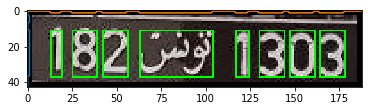

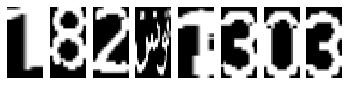

In [43]:
Tunisian_LP1 =  cv2.imread("D:\\Hawk_Eye_version_1.0_LP_recog\\Hawk_Eye_version_1.0_LP_recog\\LP_2.jpg")
char_TN_LP1 = histogram_of_pixel_projection(Tunisian_LP1)

for i in range(len(char_TN_LP1)):
    plt.subplot(1, len(char_TN_LP1), i+1)
    a=cv2.resize(char_TN_LP1[i],(20,40))
    plt.imshow(a, cmap='gray')
    plt.axis('off')

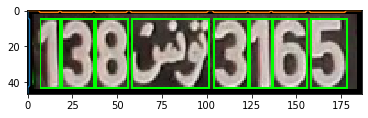

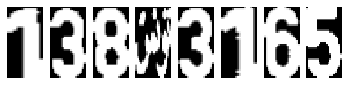

In [11]:
Tunisian_LP = cv2.imread('D:\\Hawk_Eye_version_1.0_LP_recog\\Hawk_Eye_version_1.0_LP_recog\\Licence_Plate_Recognition\\test.png')
char_Tun_LP = histogram_of_pixel_projection(Tunisian_LP)
for i in range(len(char_Tun_LP)):
    plt.subplot(1, len(char_Tun_LP), i+1)
    a=cv2.resize(char_Tun_LP[i],(20,40))
    plt.imshow(a, cmap='gray')
    plt.axis('off')

# 2- Extracting characters to prepare the dataset

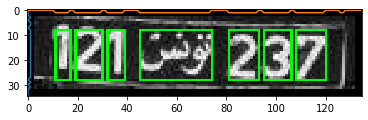

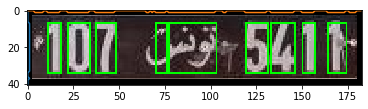

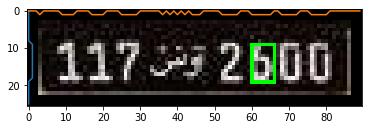

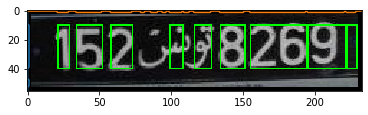

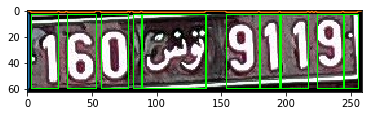

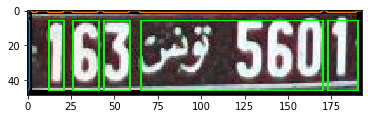

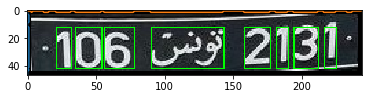

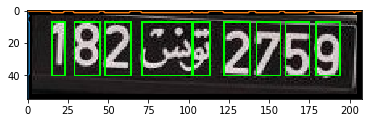

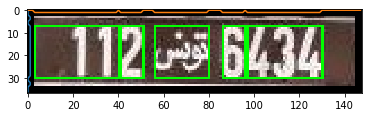

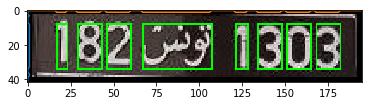

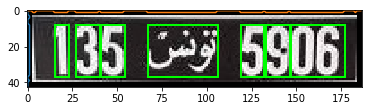

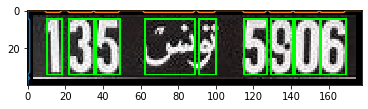

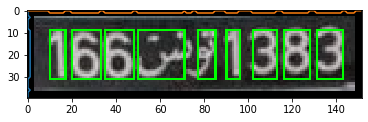

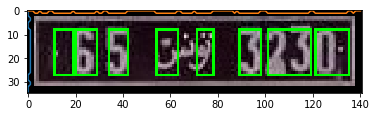

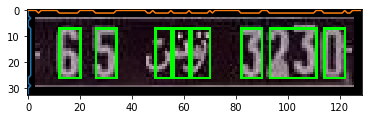

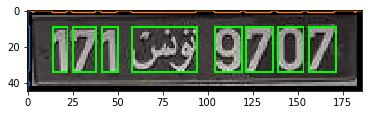

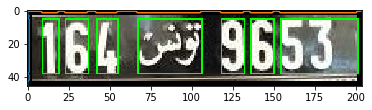

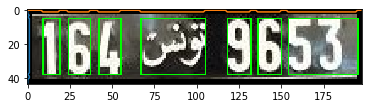

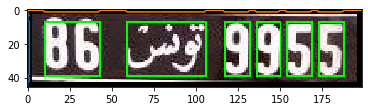

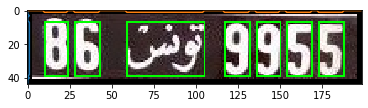

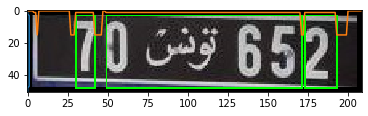

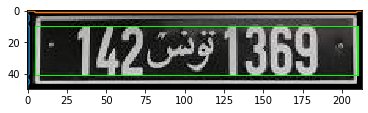

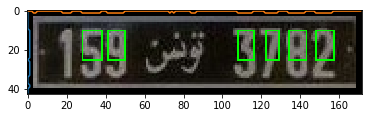

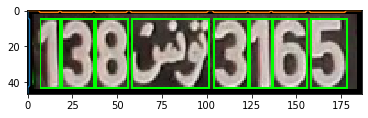

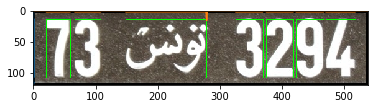

In [63]:
"""

This section is is related to the segmentation function defined above which should be improved to extract correctly the 
characters in different conditions of the LP image such as tilted position or low quality.

This should be improved using opencv in the next step.

"""
LP_folder="C:\\Users\\PC\\Desktop\\Test_plates" #the folder containing the cropped licence plates
characters_folder="C:\\Users\\PC\\Desktop\\characters" #the output folder containing the characters extracted 

def dataEnrichment(LP_folder,characters_folder):
    #number_items=len(glob.glob("{}\\*".format(folder)))
    number_items=len(glob.glob("{}\\*".format(folder)))
    for imagepath in glob.glob("{}\\*.*".format(LP_folder)):
        LP_img=cv2.imread(str(imagepath))
        char_LP=histogram_of_pixel_projection(LP_img)
        for character in char_LP:
            cv2.imwrite("{}\\{}.jpg".format(characters_folder,number_items),cv2.resize(character,(28,28)))
            number_items+=1
dataEnrichment(LP_folder,characters_folder)
#print(number_items)

## Written By : Ghassene Tanabene - September 2020
#### Intern at Chambi Eagle Technology
#### From the National School of Computer Sciences - ENSI